# Lab41

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
from sklearn.model_selection import train_test_split as split_test_train

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU
from keras.optimizers import RMSprop
from keras.callbacks import Callback
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

f:\KTU\Neuroninių tinklų metodai\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:

def gen_synthetic_data(size):
    t = np.arange(0, size)

    x = (2*np.sin(0.02*t)*np.sin(0.003*t)) + 0.5*np.random.normal(size=size)
    return pd.DataFrame(x, columns=['Data'])

def predata_dataset(data, step):
    # Pad data, so the size of X does not decrease
    # data = np.append(data, np.repeat(data[-1,], step))

    X, Y = [], []
    for i in range(len(data)-step):
        d=i+step
        X.append(data[i:d,])
        Y.append(data[d,])

    X = np.array(X)
    Y = np.array(Y)

    X = np.reshape(X, (X.shape[0], 1, step))

    return X, Y

def plot_compare(df, Tp, predicted):
    index = df.index.values
    plt.figure(figsize=(15,4))
    plt.title("Ground truth and prediction together",fontsize=18)
    plt.plot(index,df,c='blue')
    plt.plot(index,predicted,c='orange',alpha=0.75)
    plt.legend(['True data','Predicted'],fontsize=15)
    plt.axvline(df.index[Tp], c="r")
    plt.grid(True)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

def split_dataset_index(df, train_test_split):
    return int(len(df)*train_test_split)

def split_dataset(df, train_test_split):
    Tp = split_dataset_index(df, train_test_split)
    return df.values[0:Tp,:], df.values[Tp:len(df),:]

def predictions(model, trainX, testX):
    trainPredict = model.predict(trainX)
    testPredict= model.predict(testX)
    predicted = np.concatenate((trainPredict,testPredict),axis=0)

    return predicted

def build_simple_rnn(num_units=128, embedding=4,num_dense=32,lr=0.001):
    """
    Builds and compiles a simple RNN model
    Arguments:
              num_units: Number of units of a the simple RNN layer
              embedding: Embedding length
              num_dense: Number of neurons in the dense layer followed by the RNN layer
              lr: Learning rate (uses RMSprop optimizer)
    Returns:
              A compiled Keras model.
    """
    model = Sequential()
    model.add(SimpleRNN(units=num_units, input_shape=(1,embedding), activation="relu"))
    model.add(Dense(num_dense, activation="relu"))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=RMSprop(learning_rate=lr),metrics=['mse'])

    return model


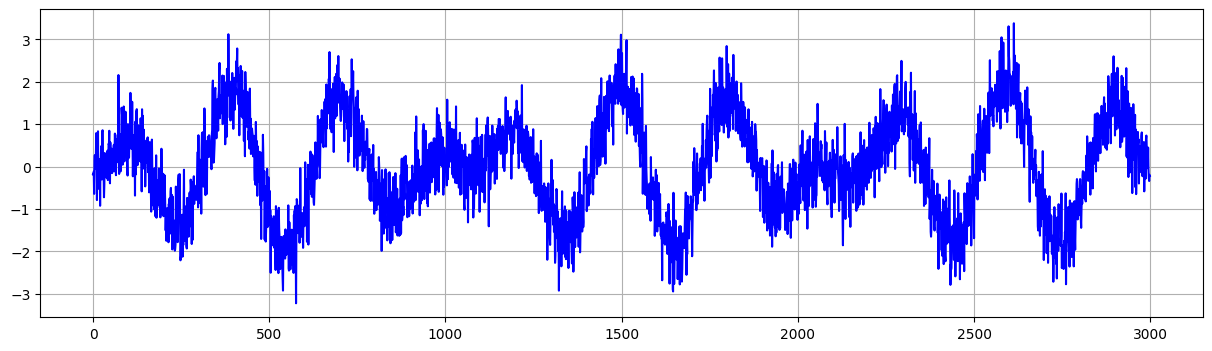

Train data length: (750, 1)
Test data length: (2250, 1)


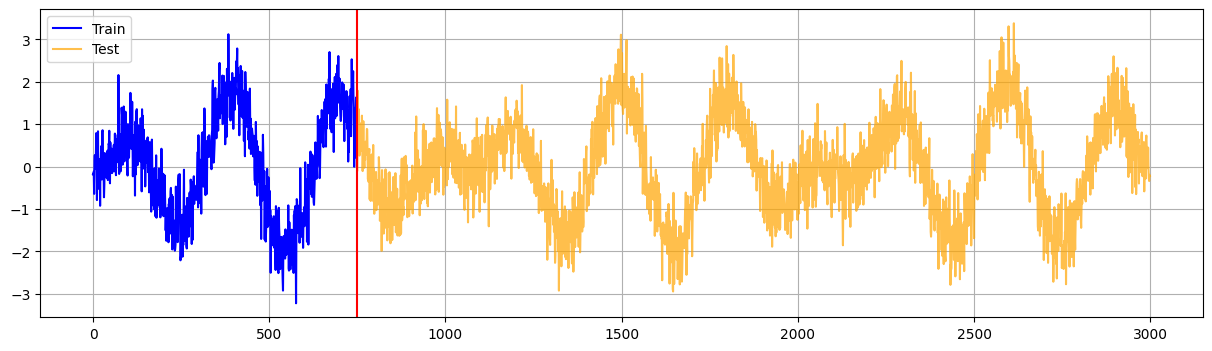

Training data shape: (750, 1, 4) ,  (750,)
Test data shape: (2250, 1, 4) ,  (2250,)


In [22]:
train_test_split = 0.25
step = 4
batch_size=16
num_epochs = 1000
df = gen_synthetic_data(3000)

plt.figure(figsize=(15,4))
plt.plot(df, c='blue')
plt.grid(True)
plt.show()

# ---------------------------

Tp = split_dataset_index(df, train_test_split)
train,test = split_dataset(df, train_test_split)
print("Train data length:", train.shape)
print("Test data length:", test.shape)

index = df.index.values
plt.figure(figsize=(15,4))
plt.plot(index[0:Tp],train,c='blue')
plt.plot(index[Tp:len(df)],test,c='orange',alpha=0.7)
plt.legend(['Train','Test'])
plt.axvline(df.index[Tp], c="r")
plt.grid(True)
plt.show()

# ---------------------------

trainX, trainY = predata_dataset(train, step)
testX , testY  = predata_dataset(test, step)

print("Training data shape:", trainX.shape,', ',trainY.shape)
print("Test data shape:", testX.shape,', ',testY.shape)


In [24]:
model = build_simple_rnn() # Taking the defaults

model.summary()

class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) % 50 == 0 and epoch>0:
            print("Epoch number {} done".format(epoch+1))

model.fit(trainX,trainY,
          epochs=num_epochs,
          batch_size=batch_size,
          callbacks=[MyCallback()],verbose=0)

model_history = model.history

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 128)               17024     
                                                                 
 dense_20 (Dense)            (None, 32)                4128      
                                                                 
 dense_21 (Dense)            (None, 1)                 33        
                                                                 
Total params: 21185 (82.75 KB)
Trainable params: 21185 (82.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
(750, 1, 4)
[[[-0.18621993 -0.19624474 -0.1204349  -0.64345478]]

 [[-0.19624474 -0.1204349  -0.64345478  0.11876486]]

 [[-0.1204349  -0.64345478  0.11876486  0.27044005]]

 ...

 [[ 1.63440001  1.31774006  1.60643767  1.60643767]]

 [[ 1.31774006  1.60643767  1.60643767  1.60643

KeyboardInterrupt: 

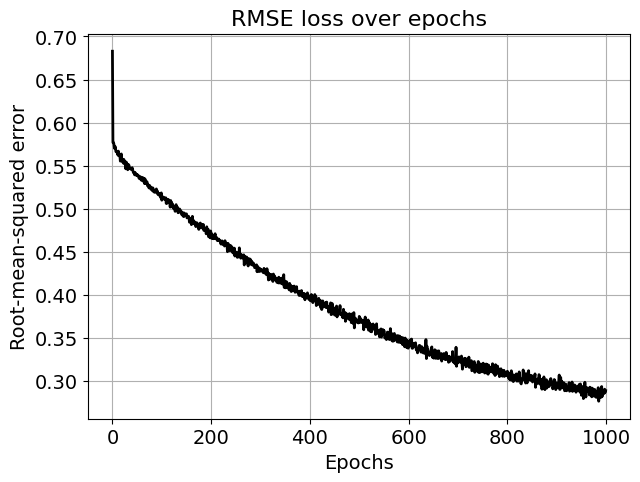

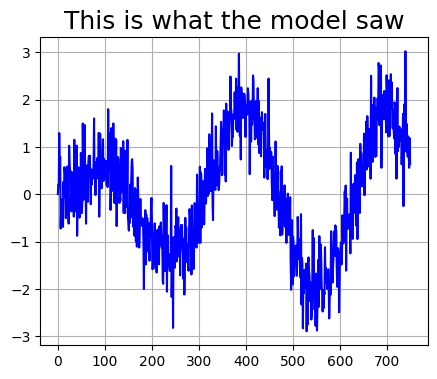

71/71 [==============================] - 0s 586us/step


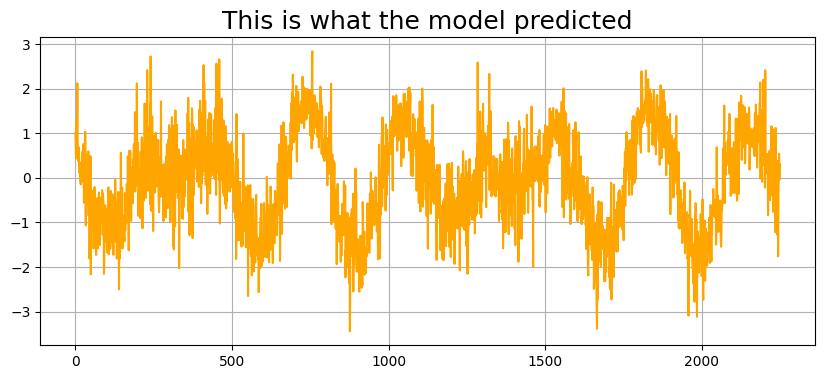

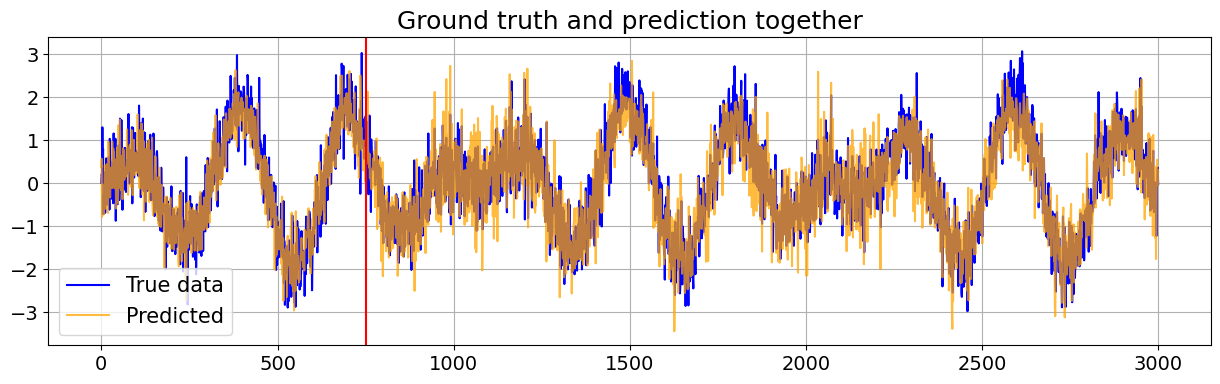

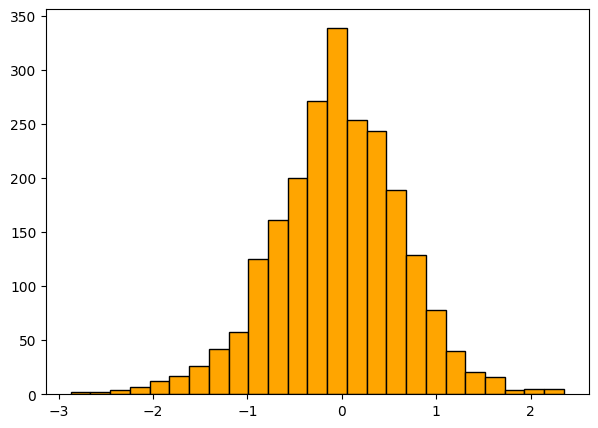

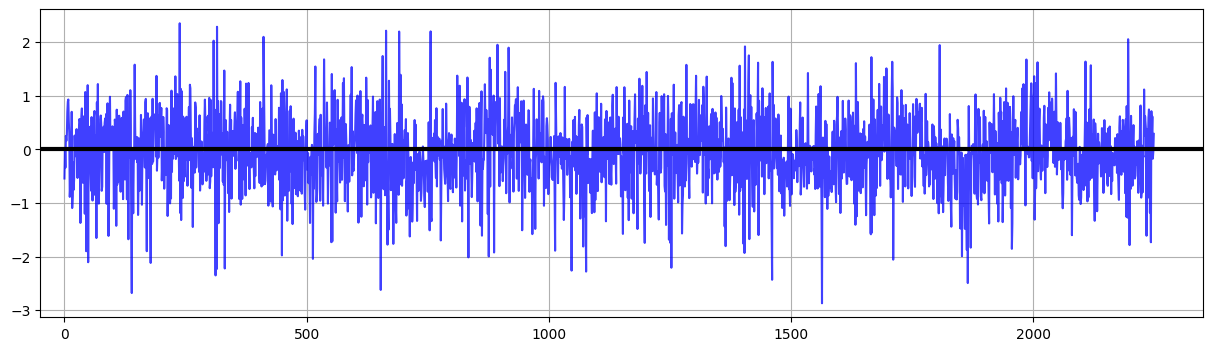

In [79]:
plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(model_history.history['loss']),c='k',lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

plt.figure(figsize=(5,4))
plt.title("This is what the model saw",fontsize=18)
plt.plot(trainX[:,0][:,0],c='blue')
plt.grid(True)
plt.show()

trainPredict = model.predict(trainX)
testPredict= model.predict(testX)
predicted=np.concatenate((trainPredict,testPredict),axis=0)

plt.figure(figsize=(10,4))
plt.title("This is what the model predicted",fontsize=18)
plt.plot(testPredict,c='orange')
plt.grid(True)
plt.show()

index = df.index.values
plt.figure(figsize=(15,4))
plt.title("Ground truth and prediction together",fontsize=18)
plt.plot(index,df,c='blue')
plt.plot(index,predicted,c='orange',alpha=0.75)
plt.legend(['True data','Predicted'],fontsize=15)
plt.axvline(df.index[Tp], c="r")
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

error=predicted[Tp:len(df)]-df[Tp:len(df)]
error=np.array(error).ravel()
plt.figure(figsize=(7,5))
plt.hist(error,bins=25,edgecolor='k',color='orange')
plt.show()

plt.figure(figsize=(15,4))
plt.plot(error,c='blue',alpha=0.75)
plt.hlines(y=0,xmin=-50,xmax=2400,color='k',lw=3)
plt.xlim(-50,2350)
plt.grid(True)
plt.show()

71/71 [==============================] - 0s 629us/step
Embedding size: 2
----------------------------------------------------------------------------------------------------


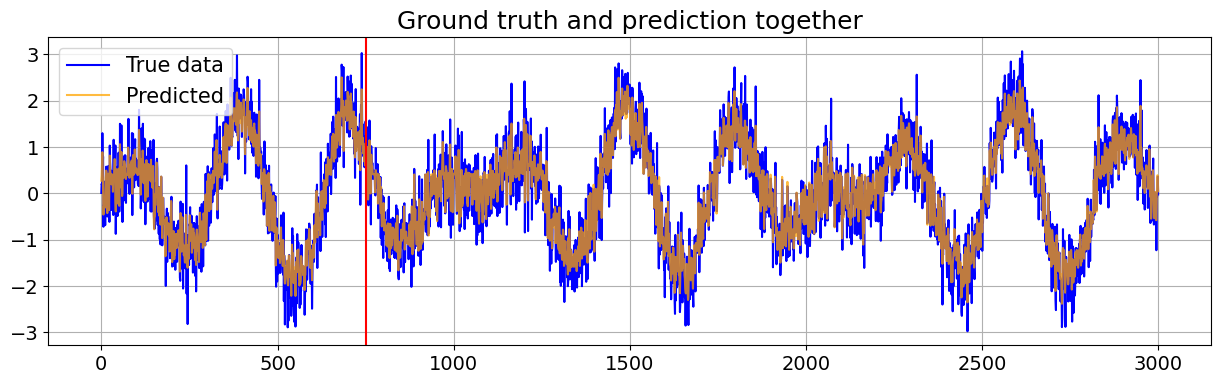


71/71 [==============================] - 0s 614us/step
Embedding size: 4
----------------------------------------------------------------------------------------------------


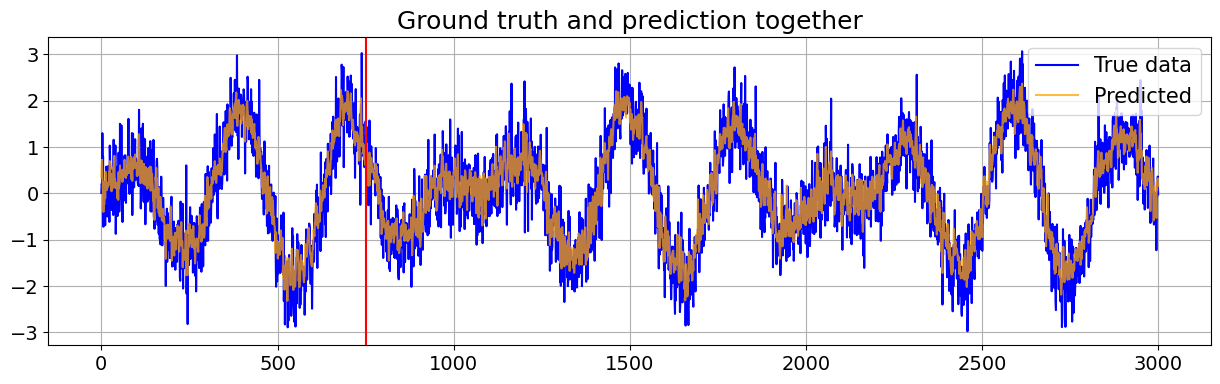


71/71 [==============================] - 0s 629us/step
Embedding size: 6
----------------------------------------------------------------------------------------------------


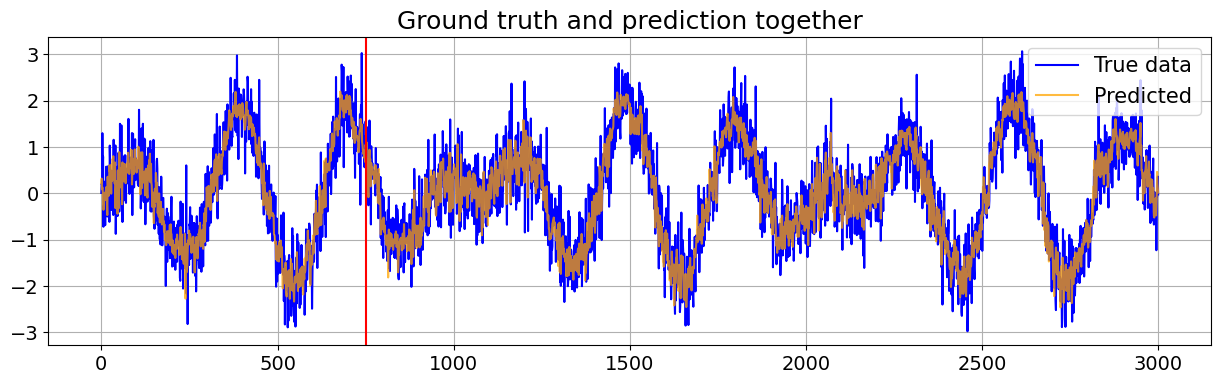


71/71 [==============================] - 0s 643us/step
Embedding size: 8
----------------------------------------------------------------------------------------------------


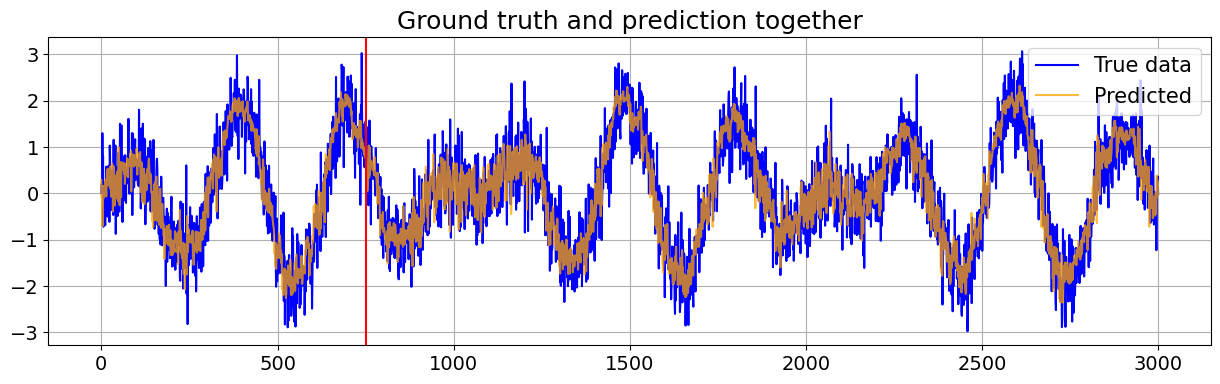


71/71 [==============================] - 0s 943us/step
Embedding size: 10
----------------------------------------------------------------------------------------------------


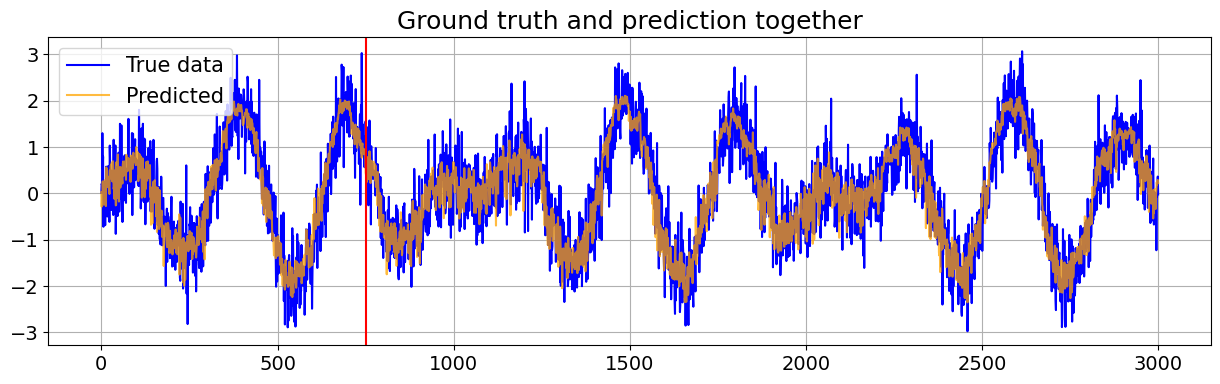


71/71 [==============================] - 0s 614us/step
Embedding size: 12
----------------------------------------------------------------------------------------------------


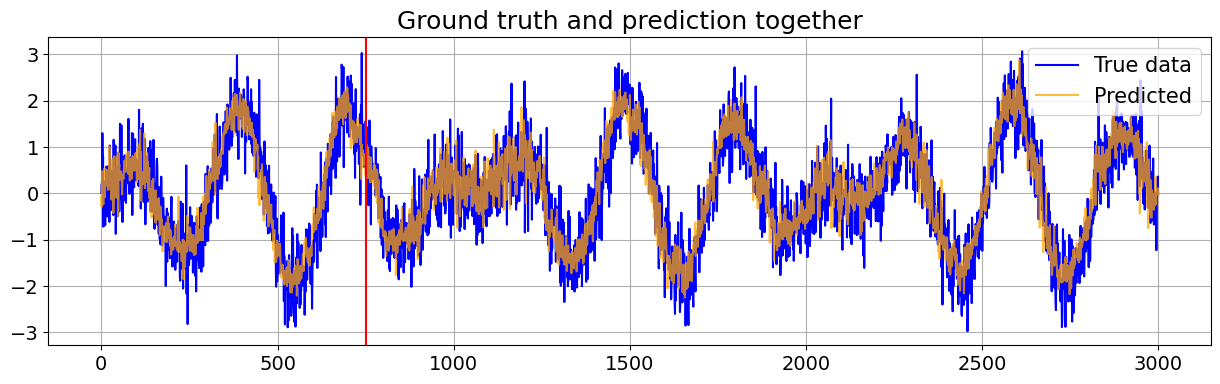

In [90]:
# Embedding size

for step in [2,4,6,8,10,12]:
      Tp = split_dataset_index(df, train_test_split)
      train,test = split_dataset(df, train_test_split)
      trainX, trainY = predata_dataset(train, step)
      testX , testY  = predata_dataset(test, step)

      model = build_simple_rnn(num_units=32,num_dense=8,embedding=step)
      batch_size = 16
      num_epochs = 100
      model.fit(
            trainX,trainY,
            epochs=num_epochs,
            batch_size=batch_size,
            verbose=0
      )
      preds = predictions(model, trainX, testX)
      print("Embedding size: {}".format(step))
      print("-"*100)
      plot_compare(df, Tp, preds)
      print()

71/71 [==============================] - 0s 643us/step
Embedding size: 4
----------------------------------------------------------------------------------------------------


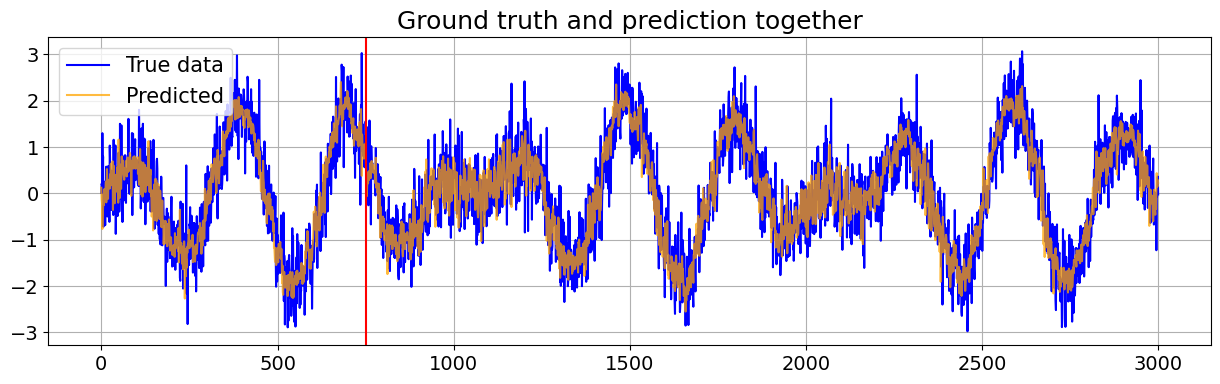


71/71 [==============================] - 0s 614us/step
Embedding size: 4
----------------------------------------------------------------------------------------------------


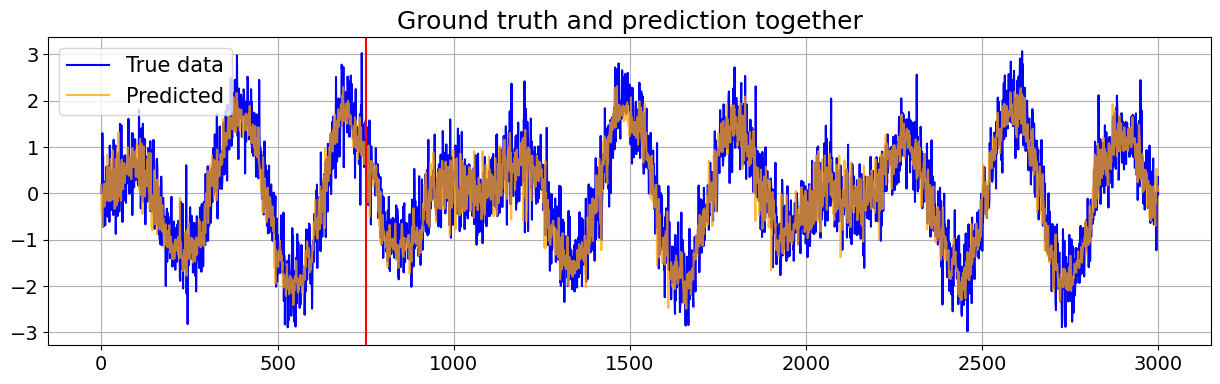


71/71 [==============================] - 0s 614us/step
Embedding size: 4
----------------------------------------------------------------------------------------------------


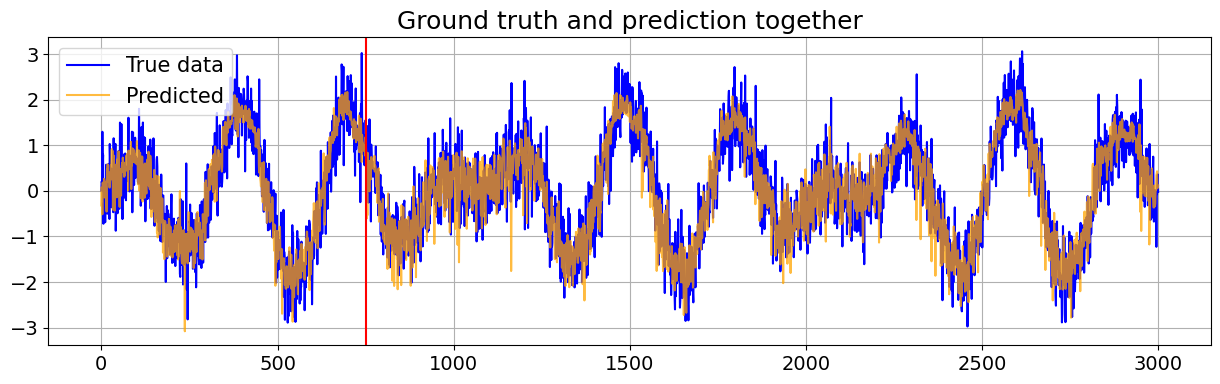


71/71 [==============================] - 0s 614us/step
Embedding size: 4
----------------------------------------------------------------------------------------------------


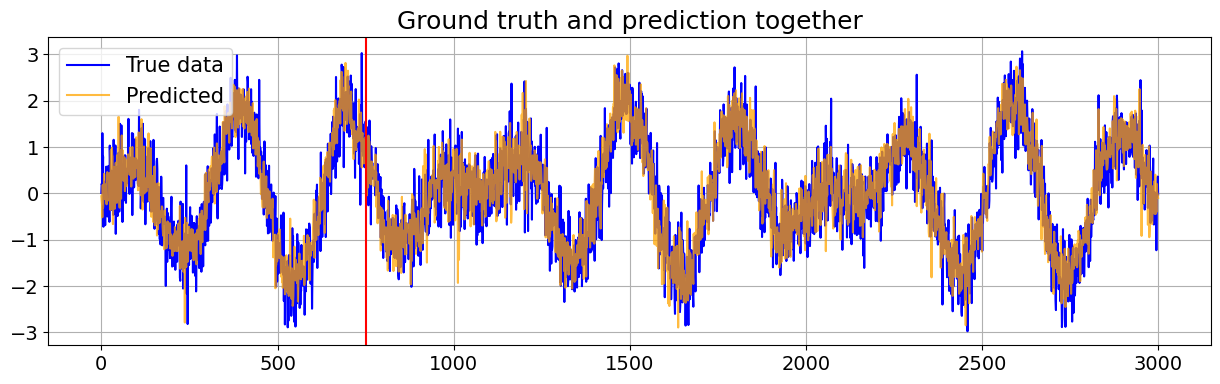


71/71 [==============================] - 0s 600us/step
Embedding size: 4
----------------------------------------------------------------------------------------------------


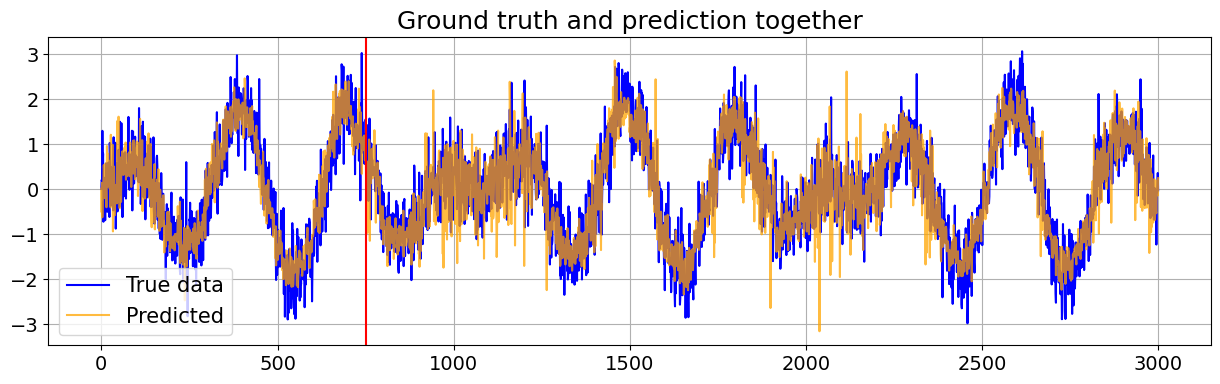

In [91]:
# Number of epochs

for num_epochs in [100,200,300,400,500]:
      Tp = split_dataset_index(df, train_test_split)
      train,test = split_dataset(df, train_test_split)
      trainX, trainY = predata_dataset(train, 8)
      testX , testY  = predata_dataset(test, 8)

      model = build_simple_rnn(num_units=32,num_dense=8,embedding=8)
      batch_size = 16
      model.fit(
            trainX,trainY,
            epochs=num_epochs,
            batch_size=batch_size,
            verbose=0
      )
      preds = predictions(model, trainX, testX)
      print("Ran for {} epochs".format(num_epochs))
      print("-"*100)
      plot_compare(df, Tp, preds)
      print()

71/71 [==============================] - 0s 614us/step
Ran with batch size: 4
----------------------------------------------------------------------------------------------------


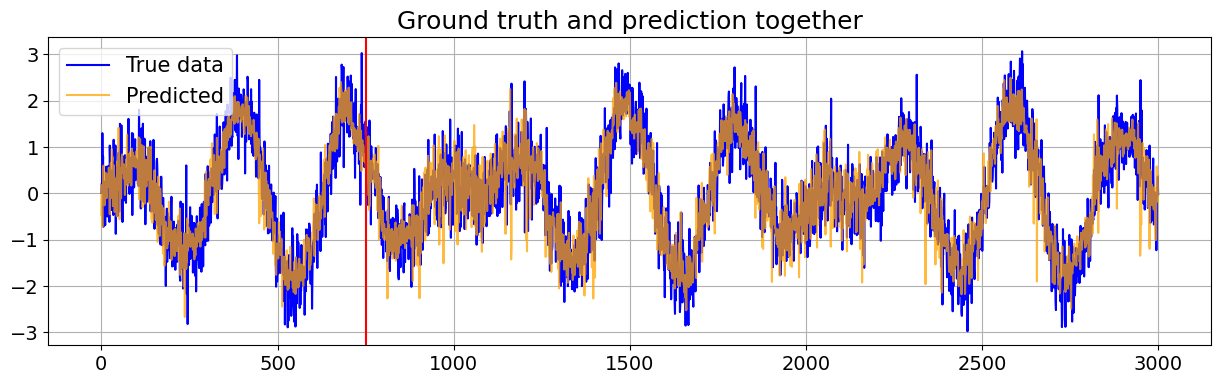


71/71 [==============================] - 0s 629us/step
Ran with batch size: 8
----------------------------------------------------------------------------------------------------


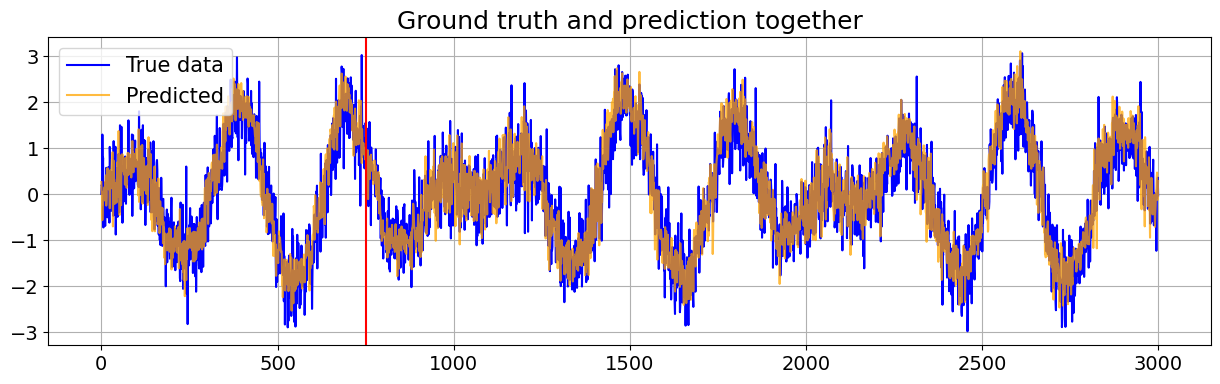


71/71 [==============================] - 0s 671us/step
Ran with batch size: 16
----------------------------------------------------------------------------------------------------


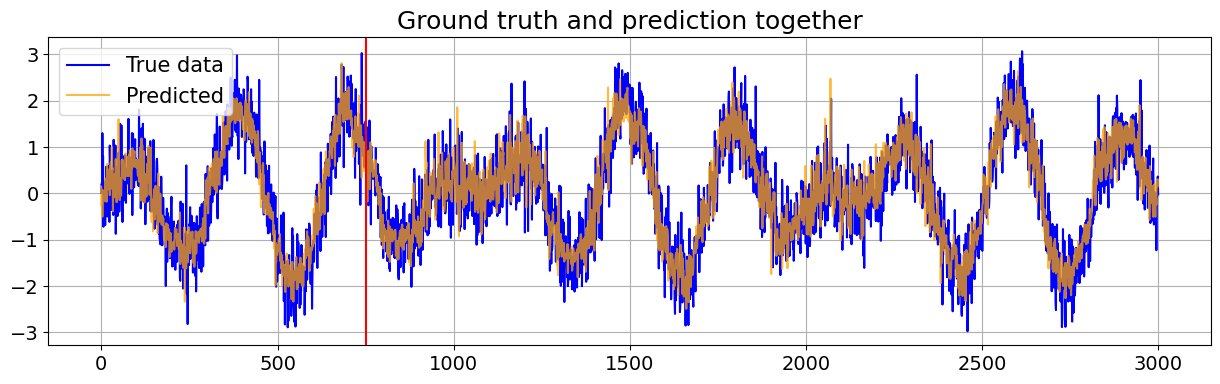


71/71 [==============================] - 0s 614us/step
Ran with batch size: 32
----------------------------------------------------------------------------------------------------


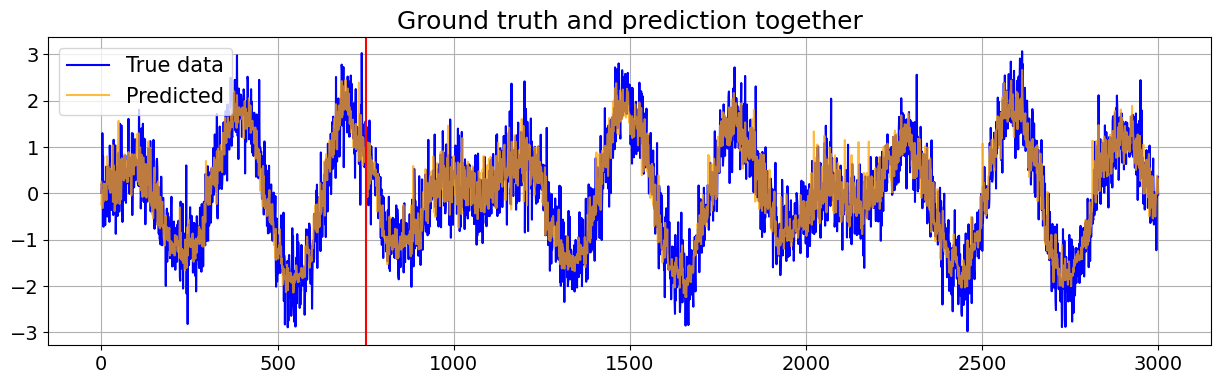


71/71 [==============================] - 0s 629us/step
Ran with batch size: 64
----------------------------------------------------------------------------------------------------


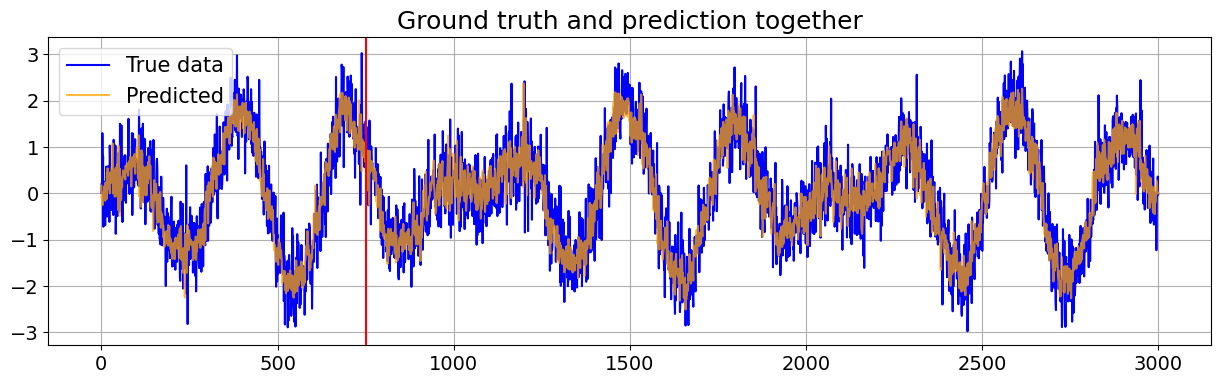

In [92]:
# Batch size

for batch_size in [4,8,16,32,64]:
      step = 8
      Tp = split_dataset_index(df, train_test_split)
      train,test = split_dataset(df, train_test_split)
      trainX, trainY = predata_dataset(train, step)
      testX , testY  = predata_dataset(test, step)

      model = build_simple_rnn(num_units=32,num_dense=8,embedding=step)
      num_epochs = 250
      model.fit(
            trainX,trainY,
            epochs=num_epochs,
            batch_size=batch_size,
            verbose=0
      )
      preds = predictions(model, trainX, testX)
      print("Ran with batch size: {}".format(batch_size))
      print("-"*100)
      plot_compare(df, Tp, preds)
      print()

### 2. Pakeiskite tinklo parametrus, architektūrą.

In [93]:
def build_custom_rnn(
        num_units=128,
        embedding=4,
        num_dense=32,
        lr=0.001,
        loss="mean_squared_error",
        rnn_activation = "relu",
        dense_activation = "relu"
    ):
    model = Sequential()
    model.add(SimpleRNN(units=num_units, input_shape=(1,embedding), activation=rnn_activation))
    model.add(Dense(num_dense, activation=dense_activation))
    model.add(Dense(num_dense/2, activation=dense_activation))
    model.add(Dense(1))
    model.compile(loss=loss, optimizer=RMSprop(learning_rate=lr),metrics=['mse'])

    return model

71/71 [==============================] - 0s 643us/step
Ran with loss: mean_squared_error
----------------------------------------------------------------------------------------------------


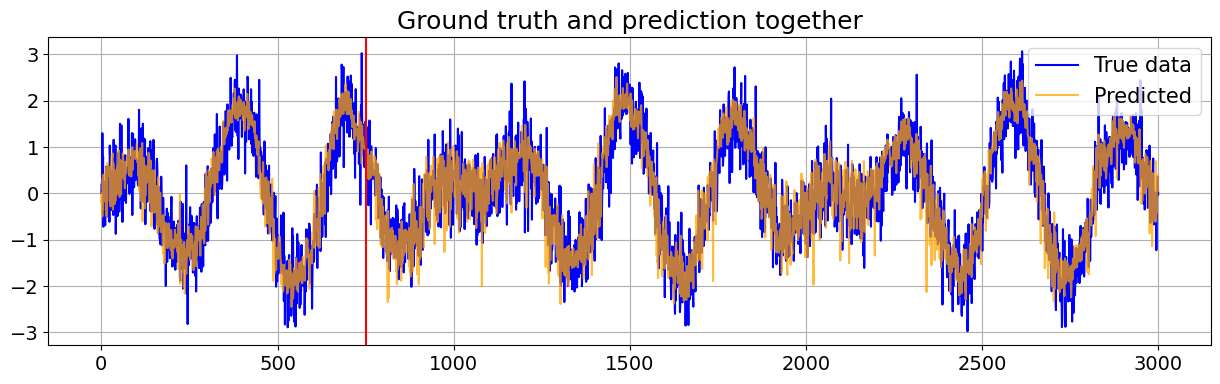


71/71 [==============================] - 0s 643us/step
Ran with loss: cosine_similarity
----------------------------------------------------------------------------------------------------


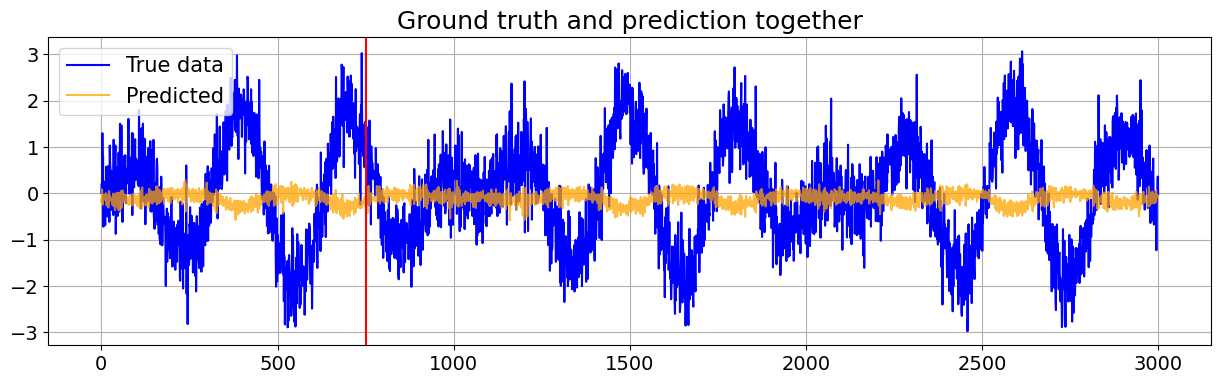


71/71 [==============================] - 0s 629us/step
Ran with loss: mean_absolute_error
----------------------------------------------------------------------------------------------------


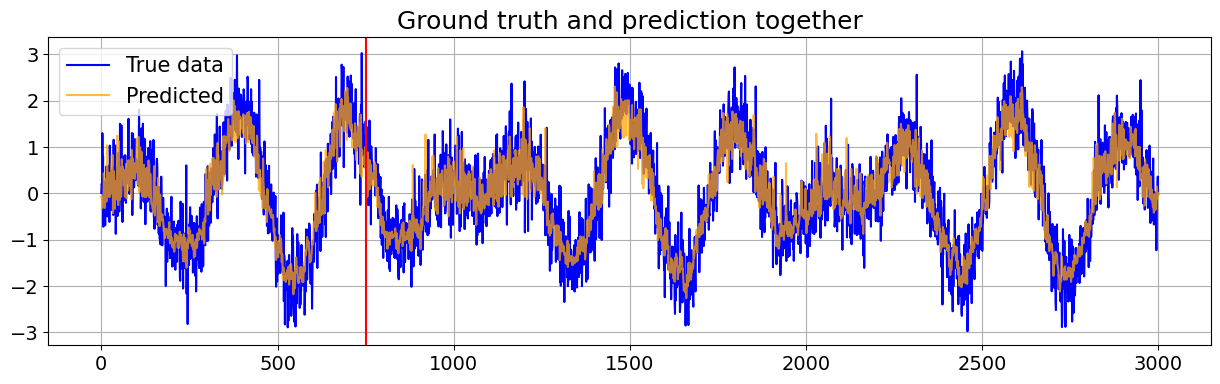


71/71 [==============================] - 0s 657us/step
Ran with loss: mean_absolute_percentage_error
----------------------------------------------------------------------------------------------------


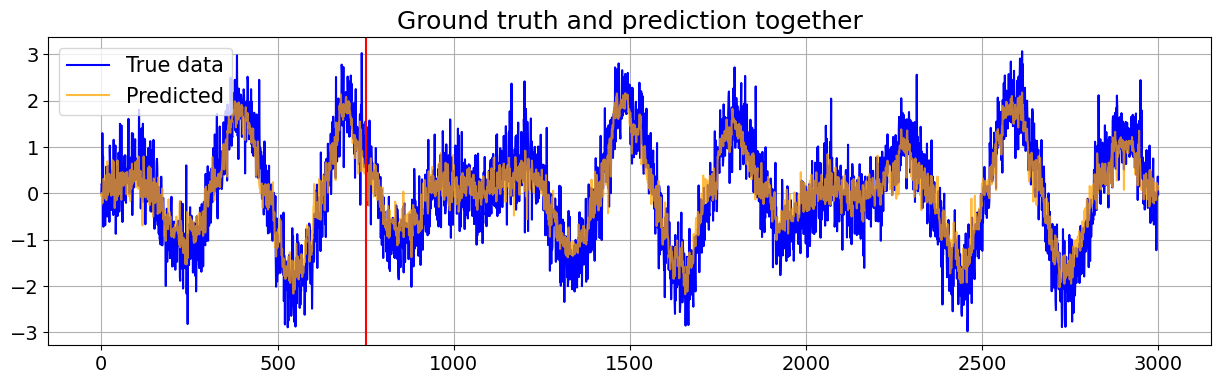

In [95]:
step = 8
Tp = split_dataset_index(df, train_test_split)
train,test = split_dataset(df, train_test_split)
trainX, trainY = predata_dataset(train, step)
testX , testY  = predata_dataset(test, step)

# Loss
for loss in ['mean_squared_error', 'cosine_similarity', 'mean_absolute_error', 'mean_absolute_percentage_error']:
    model = build_custom_rnn(num_units=32,num_dense=8,embedding=step, loss=loss)
    model.fit(
    trainX,trainY,
        epochs=250,
        batch_size=16,
        verbose=0
    )
    preds = predictions(model, trainX, testX)
    print("Ran with loss: {}".format(loss))
    print("-"*100)
    plot_compare(df, Tp, preds)
    print()

### 3. Įvertinkite modelio tikslumą ir apsimokymo greitį kuomet naudojate LSTM ir GRU blokus.

71/71 [==============================] - 0s 700us/step
Ran with builder: <function build_simple_lstm at 0x00000116CA59D9E0>
24/24 [==============================] - 0s 826us/step - loss: 0.1522 - mse: 0.1522 - accuracy: 0.0000e+00
Train metrics (mse):  0.15217162668704987
71/71 [==============================] - 0s 757us/step - loss: 0.3982 - mse: 0.3982 - accuracy: 0.0000e+00
Test metrics (mse):  0.39820733666419983
Train duration:  25.420392274856567
----------------------------------------------------------------------------------------------------


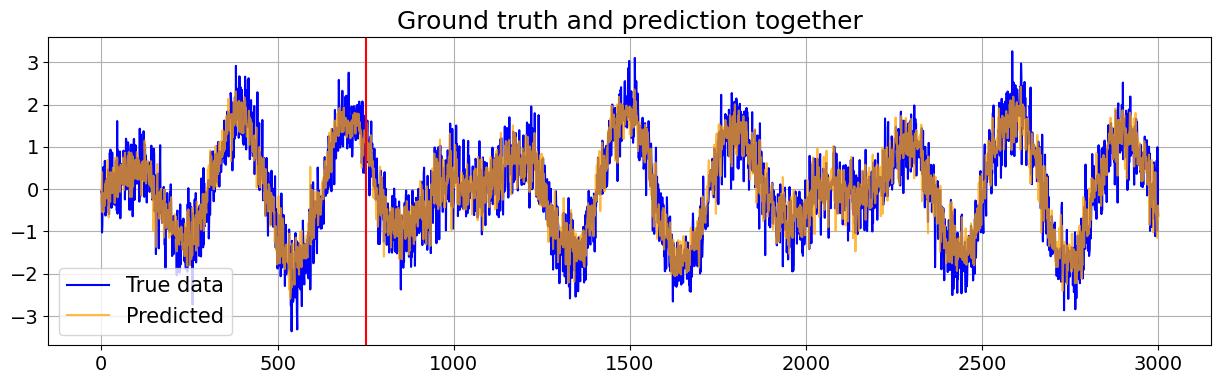


71/71 [==============================] - 0s 643us/step
Ran with builder: <function build_simple_gru at 0x00000116CA59D8A0>
24/24 [==============================] - 0s 870us/step - loss: 0.1565 - mse: 0.1565 - accuracy: 0.0000e+00
Train metrics (mse):  0.15645529329776764
71/71 [==============================] - 0s 2ms/step - loss: 0.3936 - mse: 0.3936 - accuracy: 0.0000e+00
Test metrics (mse):  0.39356908202171326
Train duration:  25.739301204681396
----------------------------------------------------------------------------------------------------


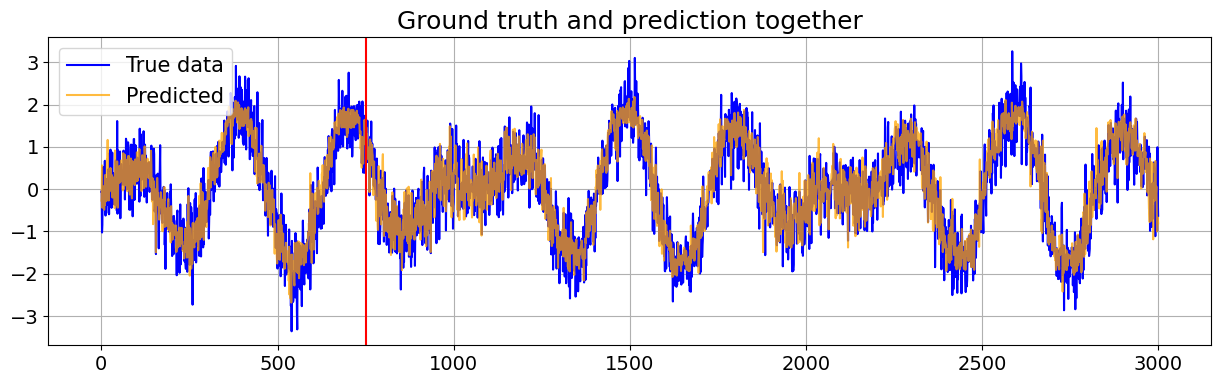

In [6]:
def build_simple_lstm(
        num_units=128,
        embedding=4,
        num_dense=32,
        lr=0.001
    ):
    model = Sequential()

    model.add(LSTM(units=num_units, input_shape=(1,embedding)))
    model.add(Dense(num_dense, activation="relu"))
    model.add(Dense(1))
    model.compile(loss="mean_squared_error", optimizer=RMSprop(learning_rate=lr),metrics=['mse', 'accuracy'])

    return model

def build_simple_gru(
        num_units=128,
        embedding=4,
        num_dense=32,
        lr=0.001
    ):
    model = Sequential()

    model.add(GRU(units=num_units, input_shape=(1,embedding)))
    model.add(Dense(num_dense, activation="relu"))
    model.add(Dense(1))
    model.compile(loss="mean_squared_error", optimizer=RMSprop(learning_rate=lr),metrics=['mse', 'accuracy'])

    return model

step = 8
Tp = split_dataset_index(df, train_test_split)
train,test = split_dataset(df, train_test_split)
trainX, trainY = predata_dataset(train, step)
testX , testY  = predata_dataset(test, step)

# Loss
for model_builder in [build_simple_lstm, build_simple_gru]:
    model = model_builder(num_units=32,num_dense=8,embedding=step)
    start_time = time()
    model.fit(
        trainX,trainY,
        epochs=500,
        batch_size=16,
        verbose=0
    )
    train_duration = time() - start_time
    preds = predictions(model, trainX, testX)
    print("Ran with builder: {}".format(model_builder))
    print("Train metrics (mse): ", model.evaluate(trainX, trainY)[1])
    print("Test metrics (mse): ", model.evaluate(testX, testY)[1])
    print("Train duration: ", train_duration)
    print("-"*100)
    plot_compare(df, Tp, preds)
    print()


### 4. Suraskite realaus pasaulio laiko eilučių duomenų rinkinį ir pritaikykite tinklą prognozei.

In [61]:
# Source: https://www.kaggle.com/datasets/shivanirana63/food-demand-forecasting

def prepare_food_dataset(df, embedding_size):
    df_X, df_Y = np.array(df.drop(columns=['num_orders'])), np.array(df['num_orders'])

    X, Y = [], []
    for i in range(len(df)-embedding_size):
        d=i+embedding_size
        X.append(df_X[i:d])
        Y.append(df_Y[d])

    X = np.array(X)
    X = np.reshape(X, (X.shape[0], len(df.columns)-1, step))

    return X, np.array(Y)

food_df = pd.read_csv('assets/train/train.csv')
del food_df['id']

embedding_size=4
train, test = split_test_train(food_df[:1_000], test_size=0.2, shuffle=False)
trainX, trainY = prepare_food_dataset(train, embedding_size)
testX, testY = prepare_food_dataset(train, embedding_size)

model = Sequential()
model.add(LSTM(units=256, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(64, activation="relu"))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer=RMSprop(learning_rate=0.001),metrics=['mse', 'accuracy'])
# loss = "mean_squared_logarithmic_error"

model.fit(
    trainX, trainY,
    batch_size=32,
    epochs=200,
    validation_data=(testX, testY)
)


Epoch 1/200
25/25 [==============================] - 2s 24ms/step - loss: 202519.4844 - mse: 202519.4844 - accuracy: 0.0000e+00 - val_loss: 190604.8438 - val_mse: 190604.8438 - val_accuracy: 0.0000e+00
Epoch 2/200
25/25 [==============================] - 0s 8ms/step - loss: 180581.4844 - mse: 180581.4844 - accuracy: 0.0000e+00 - val_loss: 170158.3125 - val_mse: 170158.3125 - val_accuracy: 0.0000e+00
Epoch 3/200
25/25 [==============================] - 0s 8ms/step - loss: 161915.5938 - mse: 161915.5938 - accuracy: 0.0000e+00 - val_loss: 153284.3594 - val_mse: 153284.3594 - val_accuracy: 0.0000e+00
Epoch 4/200
25/25 [==============================] - 0s 8ms/step - loss: 146340.6250 - mse: 146340.6250 - accuracy: 0.0000e+00 - val_loss: 139501.6719 - val_mse: 139501.6719 - val_accuracy: 0.0000e+00
Epoch 5/200
25/25 [==============================] - 0s 9ms/step - loss: 135198.8906 - mse: 135198.8906 - accuracy: 0.0000e+00 - val_loss: 131018.0000 - val_mse: 131018.0000 - val_accuracy: 0.000

25/25 [==============================] - 0s 3ms/step - loss: 50092.9062 - mse: 50092.9062 - accuracy: 0.0000e+00
Train metrics (loss, mse, accuracy):  [50092.90625, 50092.90625, 0.0]
25/25 [==============================] - 0s 2ms/step - loss: 50092.9062 - mse: 50092.9062 - accuracy: 0.0000e+00
Test metrics (loss, mse, accuracy):  [50092.90625, 50092.90625, 0.0]
Train duration:  25.739301204681396
----------------------------------------------------------------------------------------------------
25/25 [==============================] - 0s 2ms/step


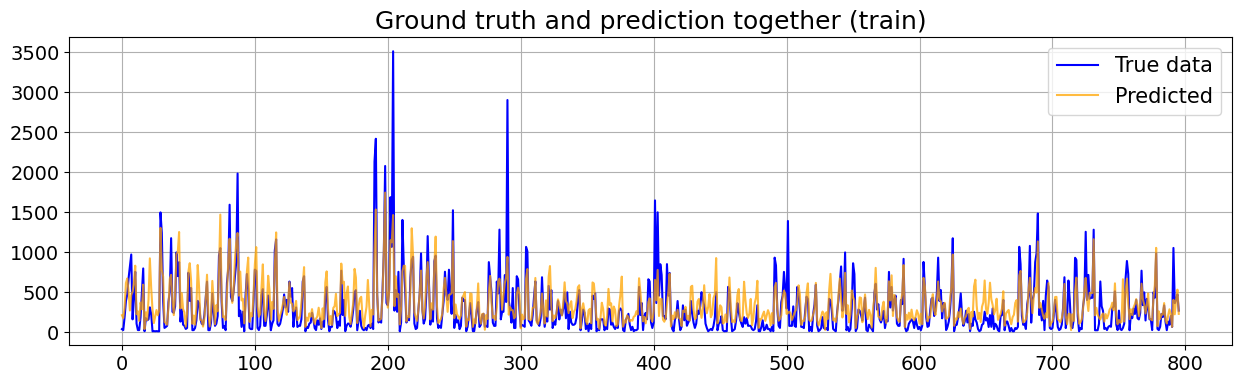


25/25 [==============================] - 0s 2ms/step


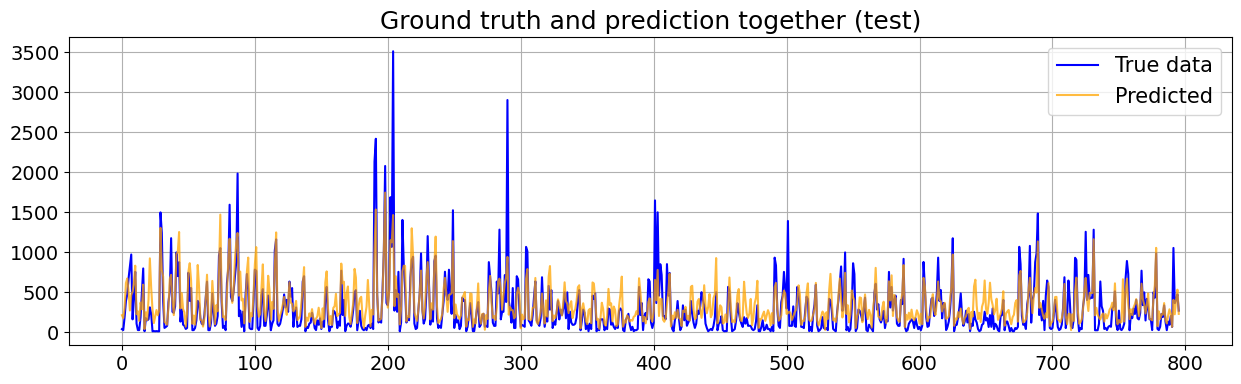

In [62]:
print("Train metrics (loss, mse, accuracy): ", model.evaluate(trainX, trainY))
print("Test metrics (loss, mse, accuracy): ", model.evaluate(testX, testY))
print("-"*100)
plt.figure(figsize=(15,4))
plt.title("Ground truth and prediction together (train)",fontsize=18)
plt.plot(trainY, c='blue')
plt.plot(model.predict(trainX),c='orange',alpha=0.75)
plt.legend(['True data','Predicted'],fontsize=15)
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()
print()

plt.figure(figsize=(15,4))
plt.title("Ground truth and prediction together (test)",fontsize=18)
plt.plot(testY, c='blue')
plt.plot(model.predict(testX),c='orange',alpha=0.75)
plt.legend(['True data','Predicted'],fontsize=15)
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()
